# Generate MNIST Images using Text-to-Image Diffusion Model

This notebook generates and saves 100 images per digit (0-9) across multiple guidance scales using the trained diffusion model.

**What this notebook does:**
- Loads the trained UNet model and CLIP text encoder
- Generates MNIST digit images from text prompts (e.g., "A handwritten digit 5")
- Tests classifier-free guidance (CFG) across different guidance scale values
- Saves generated images in organized directories for later evaluation

**Output Structure:**
```
outputs/experiment_1/generated/
├── guidance_0/
│   ├── digit_0/
│   │   ├── 0000.png
│   │   ├── 0001.png
│   │   └── ... (100 images)
│   ├── digit_1/
│   └── ... (10 digits)
├── guidance_5/
├── guidance_10/
└── ... (9 guidance scales)
```

**Configuration:**
- **Total images:** 9,000 (9 guidance scales × 10 digits × 100 images per digit)
- **Estimated time:** ~5 hours on GPU (~2 seconds per image)
- **Generation method:** Classifier-free guidance with DDPM scheduler (50 inference steps)

## 1. Setup and Configuration

In [16]:
# Project configuration - use absolute paths
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [17]:
# Import configuration and utilities
from config import (
    EXPERIMENT_1_CONFIG,
    INFERENCE_CONFIG,
    TOKENIZER_MAX_LENGTH,
    CLIP_MODEL_NAME,
    get_latest_unet_checkpoint,
    get_generated_images_dir,
    get_digit_dir,
    ensure_experiment_dirs,
)
from utils.image_utils import (
    save_image,
    folder_has_enough_images,
    count_images_in_folder,
)

# Deep learning frameworks
import torch
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

print("Libraries imported successfully")

Libraries imported successfully


In [18]:
# Load experiment configuration
GUIDANCE_SCALES = EXPERIMENT_1_CONFIG["guidance_scales"]
IMAGES_PER_DIGIT = EXPERIMENT_1_CONFIG["images_per_digit"]
DIGITS = EXPERIMENT_1_CONFIG["digits"]
PROMPT_TEMPLATE = EXPERIMENT_1_CONFIG["prompt_template"]

NUM_INFERENCE_STEPS = INFERENCE_CONFIG["num_inference_steps"]
BETA_SCHEDULE = INFERENCE_CONFIG["beta_schedule"]
NUM_TRAIN_TIMESTEPS = INFERENCE_CONFIG["num_train_timesteps"]

print("Configuration:")
print(f"  Guidance scales: {GUIDANCE_SCALES}")
print(f"  Images per digit: {IMAGES_PER_DIGIT}")
print(f"  Digits: {DIGITS}")
print(f"  Prompt template: '{PROMPT_TEMPLATE}'")
print(f"  Inference steps: {NUM_INFERENCE_STEPS}")
print(f"\nTotal images to generate: {len(GUIDANCE_SCALES) * len(DIGITS) * IMAGES_PER_DIGIT}")

Configuration:
  Guidance scales: [0, 5, 10, 15, 20, 30, 40, 50, 100]
  Images per digit: 100
  Digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Prompt template: 'A handwritten digit {digit}'
  Inference steps: 50

Total images to generate: 9000


In [19]:
# Create all necessary directories
ensure_experiment_dirs()
print("Directory structure created")

Directory structure created


## 2. Load Models

In [20]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100 80GB PCIe
Memory: 85.09 GB


In [21]:
# Import custom UNet model
from models.custom_unet import CustomUNet2DConditionModel, load_unet_from_latest_checkpoint

print("✓ Custom UNet model imported from models.custom_unet")

✓ Custom UNet model imported from models.custom_unet


In [22]:
# Load UNet from checkpoint using utility function
try:
    unet, checkpoint = load_unet_from_latest_checkpoint(device)
    unet.eval()
    
    print(f"✓ Loaded model from epoch {checkpoint['epoch']}")
    
    # Display parameter count
    num_params = unet.get_num_parameters()
    print(f"  Model parameters: {num_params:,}")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please train the model first using train1_t2i_mnist_cfg.ipynb")
    raise

Loading checkpoint: /home/doshlom4/work/final_project/checkpoints/train1_unet_checkpoint_epoch_20.pt


Loaded model from epoch 20
✓ Loaded model from epoch 20
  Model parameters: 3,140,385


In [23]:
# Load CLIP text encoder and tokenizer
text_encoder = CLIPTextModel.from_pretrained(CLIP_MODEL_NAME).to(device)
tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_NAME)

# Freeze and set to eval mode
text_encoder.requires_grad_(False)
text_encoder.eval()

print(f"✓ Loaded CLIP text encoder: {CLIP_MODEL_NAME}")
print(f"  Tokenizer max length: {TOKENIZER_MAX_LENGTH}")

✓ Loaded CLIP text encoder: openai/clip-vit-base-patch32
  Tokenizer max length: 8


## 3. Define Generation Function

In [24]:
@torch.no_grad()
def generate_image(prompt: str, guidance_scale: float, num_images: int = 1) -> torch.Tensor:
    """
    Generate MNIST images using classifier-free guidance.
    
    Args:
        prompt: Text prompt (e.g., "A handwritten digit 5")
        guidance_scale: CFG scale (0 = unconditional, higher = stronger conditioning)
        num_images: Number of images to generate
    
    Returns:
        Tensor of shape (num_images, 1, 28, 28) in range [0, 1]
    """
    # Encode text prompt
    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        truncation=True,
        return_tensors="pt"
    )
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    
    # Unconditional embeddings for classifier-free guidance
    uncond_input = tokenizer(
        [""] * num_images,
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    
    # Concatenate for CFG
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialize random noise
    latents = torch.randn((num_images, 1, 28, 28), device=device)
    
    # Setup scheduler
    scheduler = DDPMScheduler(
        beta_schedule=BETA_SCHEDULE,
        num_train_timesteps=NUM_TRAIN_TIMESTEPS
    )
    scheduler.set_timesteps(NUM_INFERENCE_STEPS)
    
    # Denoising loop
    for t in scheduler.timesteps:
        # Expand latents for CFG
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        # Predict noise
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        
        # Apply classifier-free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # Denoise step
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Post-process: reverse normalization from [-1, 1] to [0, 1]
    image = (latents / 2 + 0.5).clamp(0, 1)
    
    return image

print("✓ Generation function defined")

✓ Generation function defined


## 4. Test Generation

Generate a few test images to verify the model is working correctly.

Testing generation with:
  Prompt: 'A handwritten digit 3'
  Guidance scale: 5


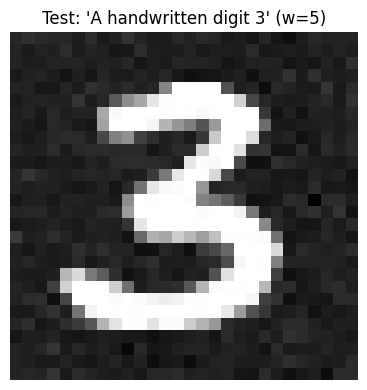

✓ Test generation successful


In [25]:
# Test generation with a single image
test_prompt = "A handwritten digit 3"
test_guidance = 5

print(f"Testing generation with:")
print(f"  Prompt: '{test_prompt}'")
print(f"  Guidance scale: {test_guidance}")

test_image = generate_image(test_prompt, guidance_scale=test_guidance, num_images=1)

# Display test image
img = test_image[0].squeeze(0).cpu().numpy()
img_uint8 = (img * 255).astype(np.uint8)

plt.figure(figsize=(4, 4))
plt.imshow(img_uint8, cmap='gray')
plt.title(f"Test: '{test_prompt}' (w={test_guidance})")
plt.axis('off')
plt.tight_layout()
plt.show()

print("✓ Test generation successful")

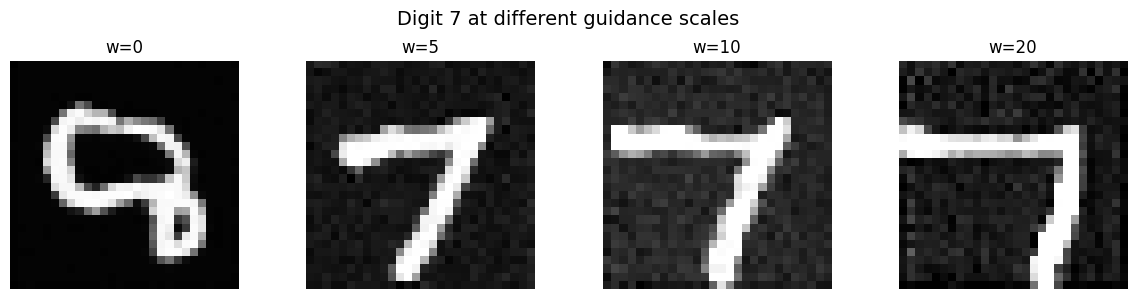

✓ Multi-scale test successful


In [26]:
# Test generation across multiple guidance scales
test_digit = 7
test_scales = [0, 5, 10, 20]

fig, axes = plt.subplots(1, len(test_scales), figsize=(12, 3))

for i, guidance_scale in enumerate(test_scales):
    prompt = PROMPT_TEMPLATE.format(digit=test_digit)
    image = generate_image(prompt, guidance_scale=guidance_scale, num_images=1)
    
    img = image[0].squeeze(0).cpu().numpy()
    img_uint8 = (img * 255).astype(np.uint8)
    
    axes[i].imshow(img_uint8, cmap='gray')
    axes[i].set_title(f'w={guidance_scale}')
    axes[i].axis('off')

fig.suptitle(f'Digit {test_digit} at different guidance scales', fontsize=14)
plt.tight_layout()
plt.show()

print("✓ Multi-scale test successful")

## 5. Check Current Progress

In [27]:
def print_generation_summary():
    """
    Print summary of what's been generated and what remains.
    """
    print("Current Generation Status:")
    print("="*70)
    
    total_needed = 0
    total_existing = 0
    
    for guidance_scale in GUIDANCE_SCALES:
        guidance_dir = get_generated_images_dir(guidance_scale)
        
        existing = 0
        for digit in DIGITS:
            digit_dir = get_digit_dir(guidance_dir, digit)
            existing += count_images_in_folder(digit_dir)
        
        expected = len(DIGITS) * IMAGES_PER_DIGIT
        needed = max(0, expected - existing)
        
        status = "✓ Complete" if needed == 0 else f"Needs {needed}"
        symbol = "✓" if needed == 0 else "⚠️"
        
        print(f"  {symbol} w={guidance_scale:3d}: {existing:4d}/{expected} - {status}")
        
        total_needed += needed
        total_existing += existing
    
    print("="*70)
    print(f"Total existing: {total_existing}")
    print(f"Total needed: {total_needed}")
    
    if total_needed > 0:
        est_time_min = total_needed * 2 / 60  # ~2 seconds per image
        est_time_hrs = est_time_min / 60
        print(f"Estimated time: ~{est_time_min:.1f} minutes (~{est_time_hrs:.1f} hours)")
    else:
        print("All images already generated! ✓")

print_generation_summary()

Current Generation Status:
  ⚠️ w=  0:    0/1000 - Needs 1000
  ⚠️ w=  5:   21/1000 - Needs 979
  ⚠️ w= 10:    0/1000 - Needs 1000
  ⚠️ w= 15:    0/1000 - Needs 1000
  ⚠️ w= 20:    0/1000 - Needs 1000
  ⚠️ w= 30:    0/1000 - Needs 1000
  ⚠️ w= 40:    0/1000 - Needs 1000
  ⚠️ w= 50:    0/1000 - Needs 1000
  ⚠️ w=100:    0/1000 - Needs 1000
Total existing: 21
Total needed: 8979
Estimated time: ~299.3 minutes (~5.0 hours)


## 6. Generate Images

Generate and save images for all guidance scales. This section provides multiple options:
- **Option A**: Generate for ALL guidance scales (takes ~5 hours)
- **Option B**: Generate for a SINGLE guidance scale (for testing)
- **Option C**: Generate for a SUBSET of guidance scales

The generation automatically skips folders that already have enough images.

In [28]:
def generate_and_save_for_guidance_scale(guidance_scale: int) -> dict:
    """
    Generate and save images for a specific guidance scale.
    
    Args:
        guidance_scale: Guidance scale value
    
    Returns:
        Dict with generation statistics
    """
    guidance_dir = get_generated_images_dir(guidance_scale)
    results = {
        "guidance_scale": guidance_scale,
        "digits": {},
        "total_generated": 0,
        "total_skipped": 0,
    }
    
    print(f"\n{'='*70}")
    print(f"Guidance scale: w={guidance_scale}")
    print(f"Output directory: {guidance_dir}")
    print(f"{'='*70}")
    
    start_time = datetime.now()
    
    for digit in DIGITS:
        digit_dir = get_digit_dir(guidance_dir, digit)
        
        # Check if already complete
        if folder_has_enough_images(digit_dir, IMAGES_PER_DIGIT):
            existing = count_images_in_folder(digit_dir)
            print(f"  Digit {digit}: Already has {existing} images ✓ (skipping)")
            results["digits"][digit] = {"generated": 0, "skipped": existing}
            results["total_skipped"] += existing
            continue
        
        # Create directory
        digit_dir.mkdir(parents=True, exist_ok=True)
        
        # Generate images
        prompt = PROMPT_TEMPLATE.format(digit=digit)
        print(f"  Digit {digit}: Generating {IMAGES_PER_DIGIT} images (prompt: '{prompt}')")
        
        digit_start = datetime.now()
        
        for i in tqdm(range(IMAGES_PER_DIGIT), desc=f"    Progress", leave=False):
            # Generate single image
            image = generate_image(prompt, guidance_scale=guidance_scale, num_images=1)
            
            # Save image
            filepath = digit_dir / f"{i:04d}.png"
            save_image(image[0], filepath, normalize=True)
        
        digit_elapsed = (datetime.now() - digit_start).total_seconds()
        print(f"    ✓ Saved {IMAGES_PER_DIGIT} images ({digit_elapsed:.1f}s, {digit_elapsed/IMAGES_PER_DIGIT:.2f}s/image)")
        
        results["digits"][digit] = {"generated": IMAGES_PER_DIGIT, "skipped": 0}
        results["total_generated"] += IMAGES_PER_DIGIT
    
    elapsed = (datetime.now() - start_time).total_seconds()
    
    print(f"\n{'='*70}")
    print(f"Guidance scale w={guidance_scale} complete!")
    print(f"  Generated: {results['total_generated']} images")
    print(f"  Skipped: {results['total_skipped']} images (already existed)")
    print(f"  Time: {elapsed:.1f}s ({elapsed/60:.1f} min)")
    if results['total_generated'] > 0:
        print(f"  Avg: {elapsed/results['total_generated']:.2f}s per image")
    print(f"{'='*70}")
    
    return results

print("✓ Generation function defined")

✓ Generation function defined


### Option A: Generate for ALL Guidance Scales

Uncomment to generate images for all guidance scales. This will take approximately 5 hours.

In [29]:
# # OPTION A: Generate for ALL guidance scales
# # Warning: This takes ~5 hours!
# 
# all_results = []
# 
# for guidance_scale in GUIDANCE_SCALES:
#     result = generate_and_save_for_guidance_scale(guidance_scale)
#     all_results.append(result)
# 
# print("\n" + "="*70)
# print("ALL GENERATION COMPLETE!")
# print("="*70)
# 
# total_generated = sum(r["total_generated"] for r in all_results)
# total_skipped = sum(r["total_skipped"] for r in all_results)
# 
# print(f"Total images generated: {total_generated}")
# print(f"Total images skipped: {total_skipped}")
# print(f"Grand total: {total_generated + total_skipped}")

print("Option A is commented out. Uncomment to run.")

Option A is commented out. Uncomment to run.


### Option B: Generate for a SINGLE Guidance Scale

Good for testing. Generates 1000 images (~30-40 minutes).

In [30]:
# OPTION B: Generate for a SINGLE guidance scale (for testing)

# Choose a guidance scale to generate
SINGLE_GUIDANCE_SCALE = 5  # Change this to any value from GUIDANCE_SCALES

print(f"Generating images for guidance scale w={SINGLE_GUIDANCE_SCALE}...")
result = generate_and_save_for_guidance_scale(SINGLE_GUIDANCE_SCALE)

print("\n" + "="*70)
print(f"Generation complete for w={SINGLE_GUIDANCE_SCALE}!")
print("="*70)

Generating images for guidance scale w=5...

Guidance scale: w=5
Output directory: /home/doshlom4/work/final_project/outputs/experiment_1/generated/guidance_5
  Digit 0: Generating 100 images (prompt: 'A handwritten digit 0')


    Progress:   0%|          | 0/100 [00:00<?, ?it/s]

    ✓ Saved 100 images (123.0s, 1.23s/image)
  Digit 1: Generating 100 images (prompt: 'A handwritten digit 1')


    ✓ Saved 100 images (122.7s, 1.23s/image)
  Digit 2: Generating 100 images (prompt: 'A handwritten digit 2')


    ✓ Saved 100 images (123.3s, 1.23s/image)
  Digit 3: Generating 100 images (prompt: 'A handwritten digit 3')


    ✓ Saved 100 images (121.6s, 1.22s/image)
  Digit 4: Generating 100 images (prompt: 'A handwritten digit 4')


    ✓ Saved 100 images (123.3s, 1.23s/image)
  Digit 5: Generating 100 images (prompt: 'A handwritten digit 5')


    ✓ Saved 100 images (123.0s, 1.23s/image)
  Digit 6: Generating 100 images (prompt: 'A handwritten digit 6')


    ✓ Saved 100 images (123.0s, 1.23s/image)
  Digit 7: Generating 100 images (prompt: 'A handwritten digit 7')


    ✓ Saved 100 images (122.5s, 1.23s/image)
  Digit 8: Generating 100 images (prompt: 'A handwritten digit 8')


    ✓ Saved 100 images (123.1s, 1.23s/image)
  Digit 9: Generating 100 images (prompt: 'A handwritten digit 9')


    ✓ Saved 100 images (123.1s, 1.23s/image)

Guidance scale w=5 complete!
  Generated: 1000 images
  Skipped: 0 images (already existed)
  Time: 1228.6s (20.5 min)
  Avg: 1.23s per image

Generation complete for w=5!


### Option C: Generate for SUBSET of Guidance Scales

Generate for specific guidance scales of interest.

In [31]:
# # OPTION C: Generate for a SUBSET of guidance scales
# 
# # Choose which guidance scales to generate
# SUBSET_GUIDANCE_SCALES = [0, 5, 10, 15, 20]  # Customize this list
# 
# print(f"Generating images for guidance scales: {SUBSET_GUIDANCE_SCALES}")
# 
# subset_results = []
# for guidance_scale in SUBSET_GUIDANCE_SCALES:
#     result = generate_and_save_for_guidance_scale(guidance_scale)
#     subset_results.append(result)
# 
# print("\n" + "="*70)
# print("SUBSET GENERATION COMPLETE!")
# print("="*70)
# 
# total_generated = sum(r["total_generated"] for r in subset_results)
# total_skipped = sum(r["total_skipped"] for r in subset_results)
# 
# print(f"Total images generated: {total_generated}")
# print(f"Total images skipped: {total_skipped}")

print("Option C is commented out. Uncomment to run.")

Option C is commented out. Uncomment to run.


## 7. Verify Generated Images

In [32]:
# Check final generation status
print_generation_summary()

Current Generation Status:
  ⚠️ w=  0:    0/1000 - Needs 1000
  ✓ w=  5: 1000/1000 - ✓ Complete
  ⚠️ w= 10:    0/1000 - Needs 1000
  ⚠️ w= 15:    0/1000 - Needs 1000
  ⚠️ w= 20:    0/1000 - Needs 1000
  ⚠️ w= 30:    0/1000 - Needs 1000
  ⚠️ w= 40:    0/1000 - Needs 1000
  ⚠️ w= 50:    0/1000 - Needs 1000
  ⚠️ w=100:    0/1000 - Needs 1000
Total existing: 1000
Total needed: 8000
Estimated time: ~266.7 minutes (~4.4 hours)


Displaying sample generated images...


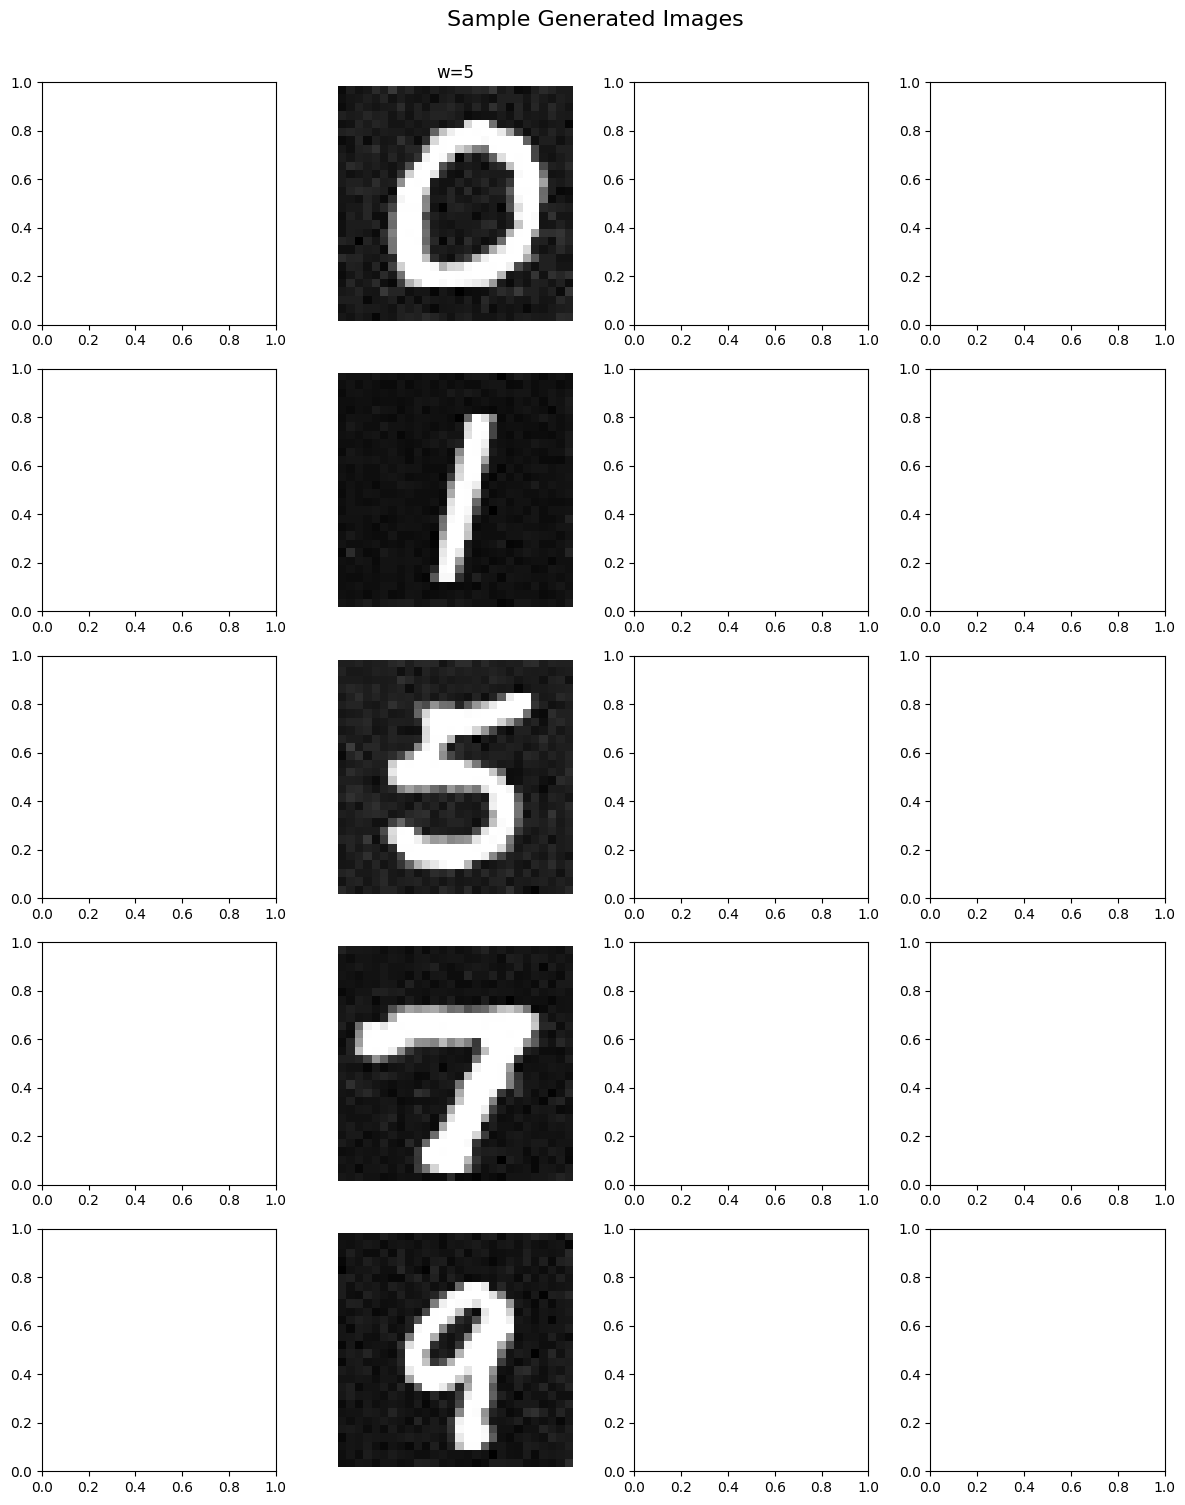

In [33]:
# Visualize sample generated images from different guidance scales
import random
from PIL import Image

def visualize_generated_samples(guidance_scales_to_show=None, digits_to_show=None, samples_per_digit=3):
    """
    Display a grid of generated images.
    """
    if guidance_scales_to_show is None:
        guidance_scales_to_show = [0, 5, 10, 20]  # Default subset
    
    if digits_to_show is None:
        digits_to_show = [0, 1, 5, 7, 9]  # Default subset
    
    fig, axes = plt.subplots(
        len(digits_to_show), 
        len(guidance_scales_to_show), 
        figsize=(3 * len(guidance_scales_to_show), 3 * len(digits_to_show))
    )
    
    for row_idx, digit in enumerate(digits_to_show):
        for col_idx, guidance_scale in enumerate(guidance_scales_to_show):
            digit_dir = get_digit_dir(get_generated_images_dir(guidance_scale), digit)
            
            if digit_dir.exists():
                # Load a random image
                images = list(digit_dir.glob("*.png"))
                if images:
                    img_path = random.choice(images)
                    img = Image.open(img_path)
                    
                    ax = axes[row_idx, col_idx] if len(digits_to_show) > 1 else axes[col_idx]
                    ax.imshow(img, cmap='gray')
                    
                    if row_idx == 0:
                        ax.set_title(f'w={guidance_scale}')
                    if col_idx == 0:
                        ax.set_ylabel(f'Digit {digit}', rotation=0, labelpad=30, fontsize=12)
                    
                    ax.axis('off')
    
    plt.suptitle('Sample Generated Images', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()

# Show samples
print("Displaying sample generated images...")
visualize_generated_samples()

## Summary

This notebook generated MNIST digit images using the trained text-to-image diffusion model with classifier-free guidance.

**What was accomplished:**
- Loaded trained UNet and CLIP text encoder models
- Generated images from text prompts across multiple guidance scales
- Saved images in structured directories organized by guidance scale and digit
- Tested generation quality with different CFG strength values

**Generated images are ready for:**
- `metrics2_evaluate_t2i_mnist.ipynb` - MNIST-specific FID and conditional accuracy evaluation
- `metrics3_pytorch_fid.ipynb` - Standard Inception-V3 FID evaluation
- Visual analysis and comparison of guidance scale effects

### Next Steps:

1. Verify all images were generated successfully (check summary in section 7)
2. Run the metrics notebooks to evaluate image quality and prompt alignment
3. Analyze how guidance scale affects generation quality and diversity

### Tips:

- Generation can be run incrementally (one guidance scale at a time)
- Already-generated images are automatically skipped
- You can resume generation at any time by re-running the appropriate option
- Each guidance scale takes approximately 30-40 minutes to complete